# Setup

In [40]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4431872/4422102 [==============================] - 1s 0us/step


In [42]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [7]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 5ms/step - loss: 1.6199 - accuracy: 0.8110 - val_loss: 0.7077 - val_accuracy: 0.8370
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7190 - accuracy: 0.8267 - val_loss: 0.7109 - val_accuracy: 0.8340


In [8]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 5ms/step - loss: 1.6258 - accuracy: 0.8127 - val_loss: 0.7562 - val_accuracy: 0.8106
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7197 - accuracy: 0.8245 - val_loss: 0.6878 - val_accuracy: 0.8382


## Dropout

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 5ms/step - loss: 0.5719 - accuracy: 0.8028 - val_loss: 0.3609 - val_accuracy: 0.8684
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4220 - accuracy: 0.8450 - val_loss: 0.3448 - val_accuracy: 0.8780


## Alpha Dropout

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

In [11]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6617 - accuracy: 0.7611 - val_loss: 0.5781 - val_accuracy: 0.8402
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5548 - accuracy: 0.7962 - val_loss: 0.5412 - val_accuracy: 0.8472
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5258 - accuracy: 0.8063 - val_loss: 0.4999 - val_accuracy: 0.8566
Epoch 4/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5052 - accuracy: 0.8123 - val_loss: 0.4794 - val_accuracy: 0.8606
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4924 - accuracy: 0.8169 - val_loss: 0.4647 - val_accuracy: 0.8616
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4832 - accuracy: 0.8202 - val_loss: 0.4871 - val_accuracy: 0.8566
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4714 - accuracy: 0.8254 - val_loss: 0.5078 - val_accuracy:

In [12]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4657 - accuracy: 0.8580


[0.4657217264175415, 0.8579999804496765]

In [13]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.3371 - accuracy: 0.8817


[0.33707743883132935, 0.8816909193992615]

In [14]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 7s 4ms/step - loss: 0.4195 - accuracy: 0.8436


## MC Dropout

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [17]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

In [18]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.48, 0.  , 0.23, 0.  , 0.28]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.31, 0.  , 0.63]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.3 , 0.  , 0.67]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.16, 0.  , 0.81]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.13, 0.  , 0.73]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.58, 0.  , 0.25]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.85, 0.  , 0.06, 0.  , 0.08]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.48, 0.  , 0.52]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.23, 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.06, 0.  , 0.87]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  , 0.05, 0.  , 0.45]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.43, 0.  , 0.  , 0.  , 0.56]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.12, 0.  , 0

In [19]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.24, 0.  , 0.59]],
      dtype=float32)

In [20]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.24, 0.  , 0.22, 0.  , 0.29]],
      dtype=float32)

In [21]:
y_pred = np.argmax(y_proba, axis=1)

In [22]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8702

In [23]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [24]:
tf.random.set_seed(42)
np.random.seed(42)

In [25]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [26]:
mc_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense_16 (Dense)            (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_17 (Dense)            (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)             

In [27]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [28]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [29]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.26, 0.  , 0.59]],
      dtype=float32)

## Max norm

In [30]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [31]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4748 - accuracy: 0.8320 - val_loss: 0.3725 - val_accuracy: 0.8654
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3539 - accuracy: 0.8722 - val_loss: 0.3704 - val_accuracy: 0.8682


# Exercises

## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.*

In [32]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [33]:
model.add(keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [34]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [35]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:

In [36]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [37]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

In [38]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 21s 12ms/step - loss: 4.0002 - accuracy: 0.1643 - val_loss: 2.1159 - val_accuracy: 0.2338
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 2.0378 - accuracy: 0.2566 - val_loss: 2.1490 - val_accuracy: 0.2252
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.9214 - accuracy: 0.2993 - val_loss: 1.9659 - val_accuracy: 0.2840
Epoch 4/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.8486 - accuracy: 0.3279 - val_loss: 1.9724 - val_accuracy: 0.3064
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.7903 - accuracy: 0.3522 - val_loss: 1.7818 - val_accuracy: 0.3592
Epoch 6/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.7434 - accuracy: 0.3663 - val_loss: 1.7422 - val_accuracy: 0.3786
Epoch 7/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.7010 - accuracy: 0.3851 - val_loss: 1

In [39]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.4767 - accuracy: 0.4860


[1.4766956567764282, 0.4860000014305115]

The model with the lowest validation loss gets about 47.6% accuracy on the validation set. It took 27 epochs to reach the lowest validation loss, with roughly 8 seconds per epoch on my laptop (without a GPU). Let's see if we can improve performance using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer. I also added a BN layer before the first hidden layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to my_cifar10_bn_model.h5.

In [43]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 37s 19ms/step - loss: 1.8461 - accuracy: 0.3368 - val_loss: 1.6690 - val_accuracy: 0.4062
Epoch 2/100
1407/1407 [==============================] - 26s 18ms/step - loss: 1.6716 - accuracy: 0.4047 - val_loss: 1.5697 - val_accuracy: 0.4356
Epoch 3/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.6027 - accuracy: 0.4304 - val_loss: 1.5443 - val_accuracy: 0.4456
Epoch 4/100
1407/1407 [==============================] - 25s 18ms/step - loss: 1.5513 - accuracy: 0.4468 - val_loss: 1.5078 - val_accuracy: 0.4570
Epoch 5/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.5060 - accuracy: 0.4658 - val_loss: 1.4446 - val_accuracy: 0.4804
Epoch 6/100
1407/1407 [==============================] - 28s 20ms/step - loss: 1.4709 - accuracy: 0.4799 - val_loss: 1.4118 - val_accuracy: 0.4986
Epoch 7/100
1407/1407 [==============================] - 27s 19ms/step - loss: 1.4348 - accuracy: 0.4886 - val_loss: 1

[1.325295090675354, 0.5360000133514404]

* *Is the model converging faster than before?* Much faster! The previous model took 27 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 5 epochs and continued to make progress until the 16th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 54.0% accuracy instead of 47.6%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 12s instead of 8s, because of the extra computations required by the BN layers. But overall the training time (wall time) was shortened significantly!

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [44]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 22s 12ms/step - loss: 1.9028 - accuracy: 0.3216 - val_loss: 1.8474 - val_accuracy: 0.3482
Epoch 2/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.6984 - accuracy: 0.3999 - val_loss: 1.7947 - val_accuracy: 0.3474
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.6019 - accuracy: 0.4346 - val_loss: 1.7130 - val_accuracy: 0.3970
Epoch 4/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.5365 - accuracy: 0.4613 - val_loss: 1.6063 - val_accuracy: 0.4456
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4802 - accuracy: 0.4825 - val_loss: 1.5612 - val_accuracy: 0.4598
Epoch 6/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.4378 - accuracy: 0.4985 - val_loss: 1.5162 - val_accuracy: 0.4764
Epoch 7/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.3913 - accuracy: 0.5130 - val_loss: 1

[1.479697346687317, 0.4885999858379364]

In [45]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.4797 - accuracy: 0.4886


[1.479697346687317, 0.4885999858379364]

We get 47.9% accuracy, which is not much better than the original model (47.6%), and not as good as the model using batch normalization (54.0%). However, convergence was almost as fast as with the BN model, plus each epoch took only 7 seconds. So it's by far the fastest model to train so far.

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [46]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 28s 16ms/step - loss: 1.8815 - accuracy: 0.3278 - val_loss: 1.7211 - val_accuracy: 0.4020
Epoch 2/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.6534 - accuracy: 0.4176 - val_loss: 1.6282 - val_accuracy: 0.4244
Epoch 3/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.5634 - accuracy: 0.4507 - val_loss: 1.6071 - val_accuracy: 0.4334
Epoch 4/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.5011 - accuracy: 0.4714 - val_loss: 1.5902 - val_accuracy: 0.4504
Epoch 5/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.4433 - accuracy: 0.4918 - val_loss: 1.5304 - val_accuracy: 0.4636
Epoch 6/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.3919 - accuracy: 0.5127 - val_loss: 1.5480 - val_accuracy: 0.4864
Epoch 7/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.3560 - accuracy: 0.5258 - val_loss: 1

[1.4859399795532227, 0.49639999866485596]

The model reaches 48.9% accuracy on the validation set. That's very slightly better than without dropout (47.6%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [47]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [48]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [49]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [50]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.497

We get no accuracy improvement in this case (we're still at 48.9% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [63]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [64]:
import math

In [65]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

352/352 [==============================] - 6s 14ms/step - loss: nan - accuracy: 0.1368


(9.999999747378752e-06,
 9.615227699279785,
 2.611842393875122,
 4.002453429358346)

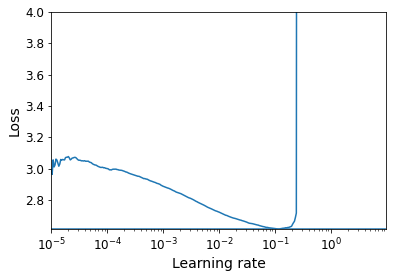

In [66]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [67]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [68]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [69]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 6s 15ms/step - loss: 2.0517 - accuracy: 0.2890 - val_loss: 1.7945 - val_accuracy: 0.3772
Epoch 2/15
352/352 [==============================] - 5s 15ms/step - loss: 1.7612 - accuracy: 0.3758 - val_loss: 1.6345 - val_accuracy: 0.4232
Epoch 3/15
352/352 [==============================] - 5s 14ms/step - loss: 1.6161 - accuracy: 0.4255 - val_loss: 1.6279 - val_accuracy: 0.4294
Epoch 4/15
352/352 [==============================] - 5s 14ms/step - loss: 1.5418 - accuracy: 0.4572 - val_loss: 1.6117 - val_accuracy: 0.4348
Epoch 5/15
352/352 [==============================] - 5s 14ms/step - loss: 1.4917 - accuracy: 0.4715 - val_loss: 1.5634 - val_accuracy: 0.4650
Epoch 6/15
352/352 [==============================] - 5s 15ms/step - loss: 1.4498 - accuracy: 0.4854 - val_loss: 1.5302 - val_accuracy: 0.4766
Epoch 7/15
352/352 [==============================] - 5s 16ms/step - loss: 1.4133 - accuracy: 0.4984 - val_loss: 1.6117 - val_accuracy: 0.4444

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 47.6% to 52.0%). The batch normalized model reaches a slightly better performance (54%), but it's much slower to train.